# Forecasting Revenue  - ARIMA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

### Loading and Cleaning the Data

In [2]:
#loading data from GitHub Repository 
url = 'https://raw.githubusercontent.com/arunagossai/Forecasting_ARMA_Python/master/EU-UK.csv'
df = pd.read_csv(url)

#Changing the format of 'DATE' to date python can read 
for i in range(0,len(df['DATE'])): #range(0,len(df['DATE']))
    df['DATE'][i] = datetime.datetime.strptime(df['DATE'][i], '%m/%d/%Y')
df['DATE'] = pd.to_datetime(df['DATE'])

df['Qdate'] = pd.PeriodIndex(df['DATE'],freq='Q') #do I need this

#Creates column needed for dummy variables
df['Quarter'] = df['DATE'].dt.quarter 
dummies = pd.get_dummies(df['Quarter'], prefix='Q', drop_first = True)
df = pd.concat([df,dummies], axis = 1) 

#Subsetting data
df = df[df.EU != '.' ] 
df['EU'] = np.array(df['EU']).astype(float) #changing the data type from string to numeric
df['UK'] = np.array(df['UK']).astype(float)
df['UK.log'] = np.log(df['UK'])

#for i in range(0,len(df['EU'])):
#    df['EU_d1'][i+1] = df['EU'][i+1]-df['EU'][i]
    
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,DATE,EU,UK,Qdate,Quarter,Q_2,Q_3,Q_4,UK.log
80,1995-01-01,1776636.5,207208.0,1995Q1,1,0,0,0,12.241478
81,1995-04-01,1819739.8,207339.0,1995Q2,2,1,0,0,12.242110
82,1995-07-01,1832253.3,213418.0,1995Q3,3,0,1,0,12.271008
83,1995-10-01,1936764.2,222197.0,1995Q4,4,0,0,1,12.311320
84,1996-01-01,1857978.8,220550.0,1996Q1,1,0,0,0,12.303880


### Visualizing the Series to be Forecasted

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


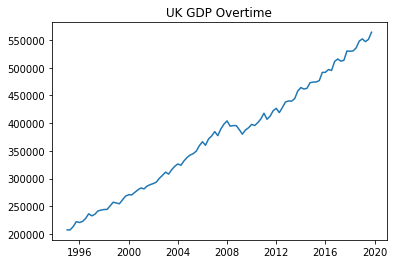

In [3]:
plt.plot(df['DATE'],df['UK'])
plt.title('UK GDP Overtime')
plt.show()

From this graph it is apparent that there is a linear trend over time and seasonality. The seasonality can be seen by the jagged lines.

### Test for Stationarity - Augmented Dickey Fuller

In [4]:
#The series that you forecast must be stationary before you use an ARIMA or ARMA model. 

result = adfuller(df['EU'], regression='c') #the null for ADF: series is not stationary
print('With a constant')
print('ADF Statistic:', result[0])
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
#ctt = constant, linear trend, quadratic trend; nc = no constant or trend
result_trend = adfuller(np.diff(df['EU'],n=1), regression='c') #ADF with constant and linear trend 
print('\nWith a constant and trend')
print('ADF Statistic:', result_trend[0])
print('p-value:', result_trend[1])

With a constant
ADF Statistic: -0.3157657722906795
p-value: 0.9232415565461722
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872

With a constant and trend
ADF Statistic: -2.5319445090557435
p-value: 0.10789405671183377


Had to take the first difference because the series was not stationary with a linear trend. Used the first difference and tested for stationarity with a constant. Significant at the 10% level.

### Building the Model from the Auto Correlations and Partial Auto Correlations

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported

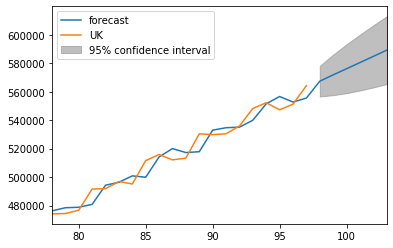

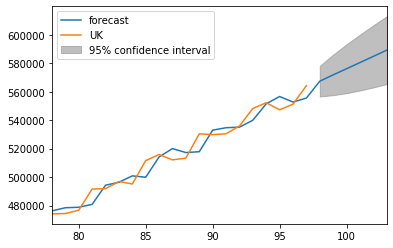

In [7]:
ar1ma1 = ARIMA(df['UK'], order=(1,2,1)) #AR=2 Difference=2 MA=2
results = ar1ma1.fit()
results.plot_predict(80,105)